# Hate Speech Detector 2.0
---
**Deep Learning vectorized text classifier** - Dense NN

1. Load lemmatized tweets.
2. Load best vectorizer from previous task (**manually, supervisedly trained FastText vectorizer**).
3. Implement deep learning **dense NN** model classifiers with appropriate dataset class. Adapt Deep Learning models to Classifier interface.
4. Perform multilabel classification task.
5. Visualize results by 7 different hate-speech labels plus 1 overall confusion matrices.
6. Perform some test on independent sanitized tweets about polish courts.

**Class weight types**
1. (0) --> 1/(class card.)
2. (1) --> (all examples card.)/(class card.)
3. (2) --> 2 - (class card.)/(all examples card.)
4. (n) --> 1

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.classifiers.DLVectorClassifier import DLVectorClassifier
from src.vectorizers.TextOwnTrainedFTVectorizer import TextOwnTrainedFTVectorizer
from src.nn.models import DenseNet
from src.dataframes.utils import classes, combine_row_wisely, shuffle_dataframe, class_weights
from src.visualization.classification import confusion_matrices, models_quality_plot, best_model_for_class
from src.constants import (LABELS,
                           DUPLICATED_PATH, COMBINED_TESTONLY_PATH,
                           DLDC_CHART_DIR)

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
WEIGHT_TYPE = 2

In [4]:
plt.style.use('ggplot')

## Data loading

### Classes

In [5]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


In [6]:
df_test_classes = pd.read_csv(COMBINED_TESTONLY_PATH)[LABELS]
df_test_classes = classes(df_test_classes, convert_null=True)
df_test_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


### Lemmatized tweets

In [7]:
df_lemmatized = pd.read_csv(DUPLICATED_PATH)[['tweet']]
df_lemmatized.head(2)

,tweet
0,w czwartek muszę poprawić sądy i trybunały
1,Żale Nałęcza i riposta Macierewicza: Pan był w...


In [8]:
df_test_lemmatized = pd.read_csv(COMBINED_TESTONLY_PATH)[['tweet']]
df_test_lemmatized.head(2)

,tweet
0,"Warto poznać Śląsk i Ślązaków, zanim zacznie s..."
1,jeszcze nie są całkiem bezkarni.Sądy jeszcze t...


### Combined data

In [9]:
df_data = combine_row_wisely([df_lemmatized, df_classes])
df_data = shuffle_dataframe(df_data)
df_data.head(2)

,tweet,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
2553,Sądy pomagają osobom uwięzionym w CHF:,0,0,0,0,0,0,0
1212,1/2 Na szczęście w tej dziedzinie sądy mnie j...,0,0,0,0,0,0,0


In [10]:
df_test_data = combine_row_wisely([df_test_lemmatized, df_test_classes])
df_test_data.head(2)

,tweet,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,"Warto poznać Śląsk i Ślązaków, zanim zacznie s...",0,0,0,0,0,0,0
1,jeszcze nie są całkiem bezkarni.Sądy jeszcze t...,0,0,0,0,0,0,0


### Class weights

In [11]:
weights = class_weights(df_classes, w_type=WEIGHT_TYPE)
wlabel = f'w{WEIGHT_TYPE}'
weights

array([1.96630992, 1.95459439, 1.9713761 , 1.9734659 , 1.9341397 ,
       1.93059338, 1.99620037])

## Models implementation and testing

In [12]:
MODEL_KWARGS = [{'hidden_size': 500, 'drop_coeff': 0.1, 'n_linear': 3},
                {'hidden_size': 300, 'drop_coeff': 0.1, 'n_linear': 3},
                {'hidden_size': 500, 'drop_coeff': 0., 'n_linear': 3},
                {'hidden_size': 300, 'drop_coeff': 0., 'n_linear': 3},
                {'hidden_size': 500, 'drop_coeff': 0.1, 'n_linear': 1},
                {'hidden_size': 300, 'drop_coeff': 0.1, 'n_linear': 1},
                {'hidden_size': 500, 'drop_coeff': 0., 'n_linear': 1},
                {'hidden_size': 300, 'drop_coeff': 0., 'n_linear': 1}]
MODEL_LABELS = ['500-1-3', '300-1-3', '500-0-3', '300-0-3',
                '500-1-1', '300-1-1', '500-0-1', '300-0-1']

In [13]:
X_data = df_data.drop(LABELS, axis=1).values
y_data = df_data[LABELS].values

X_test_data = df_test_data.drop(LABELS, axis=1).values
y_test_data = df_test_data[LABELS].values

y_preds = list([])

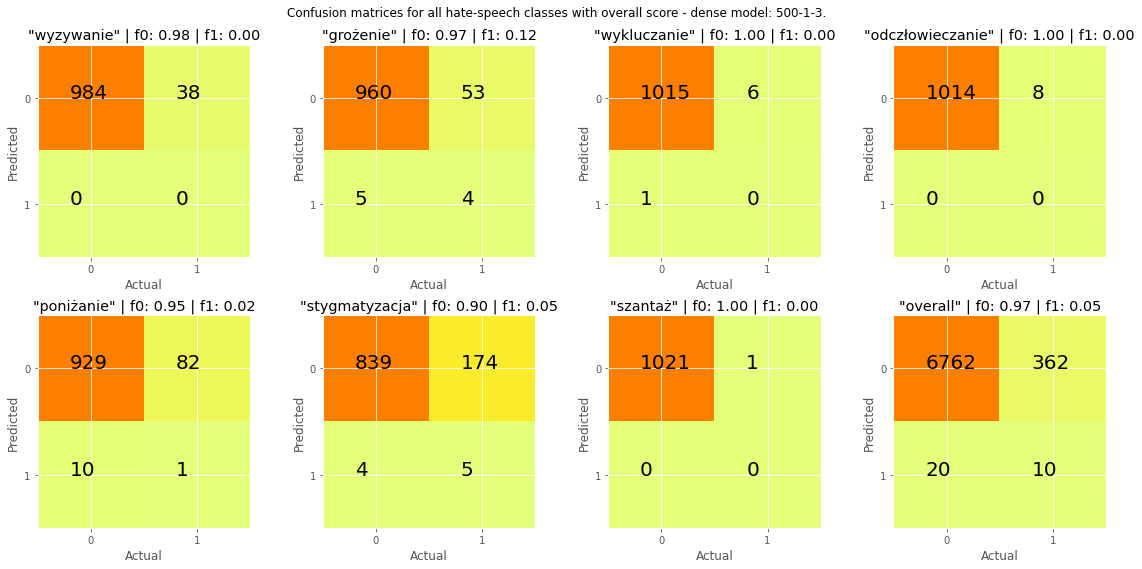

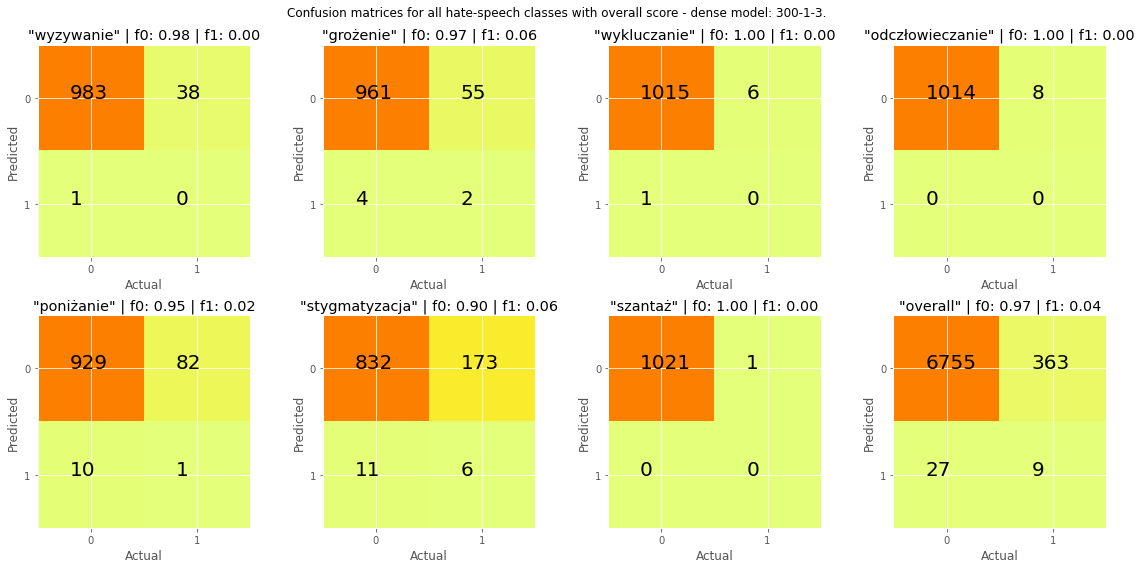

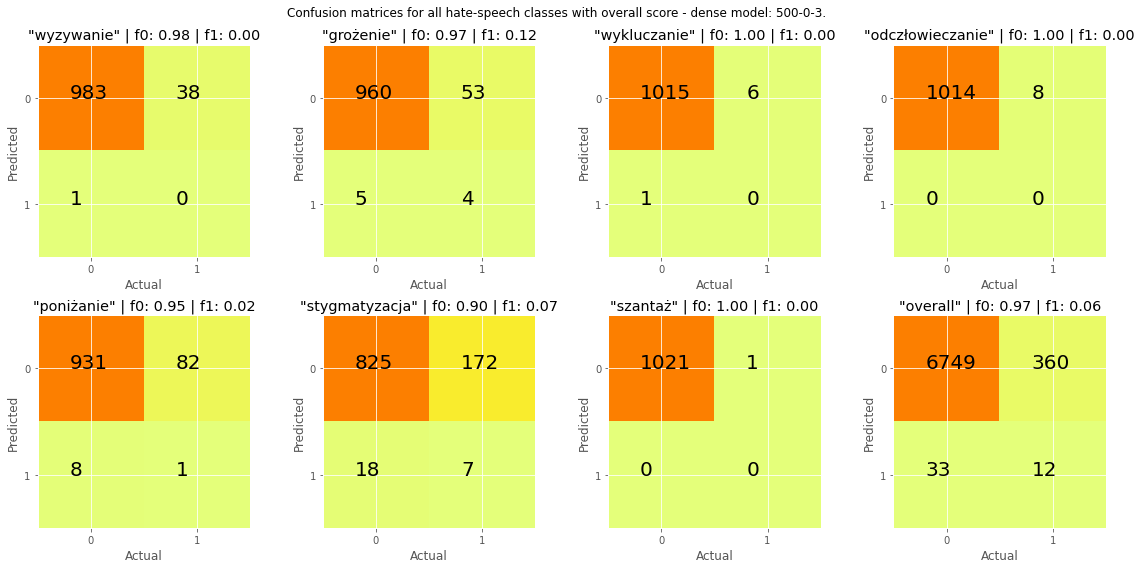

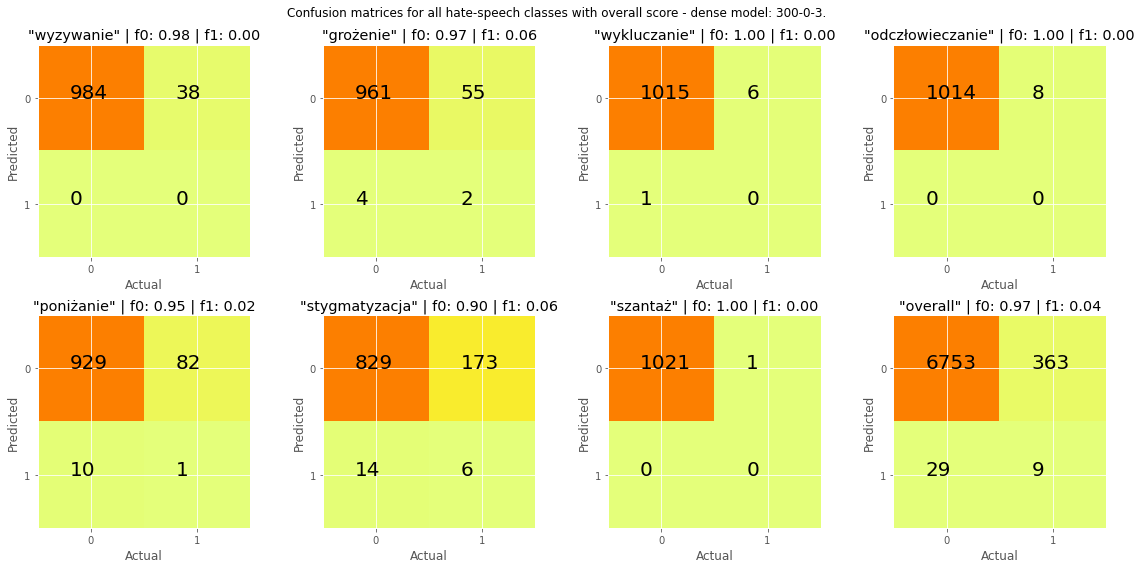

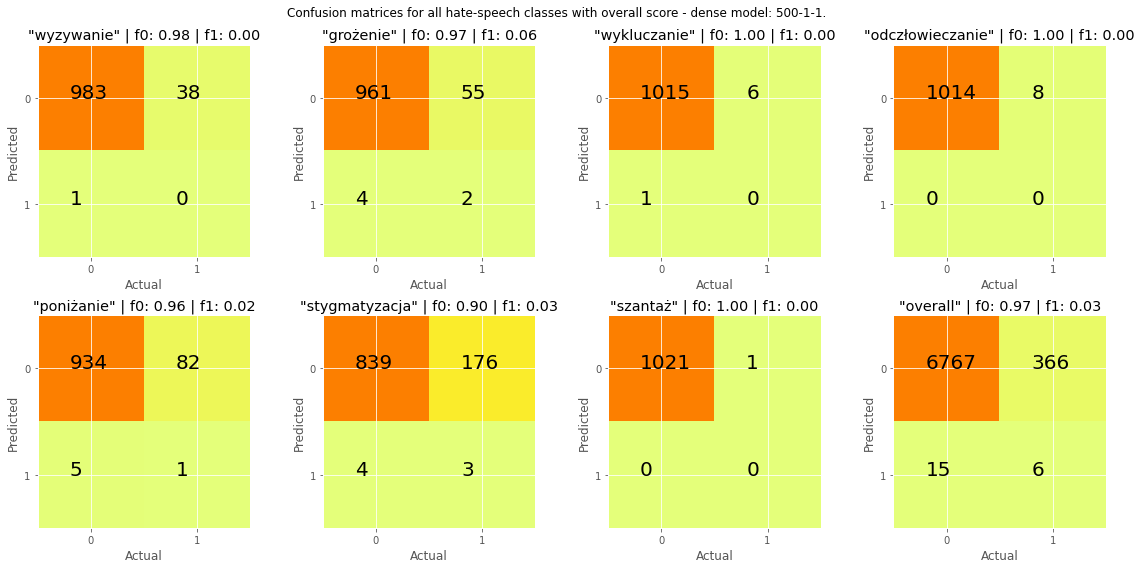

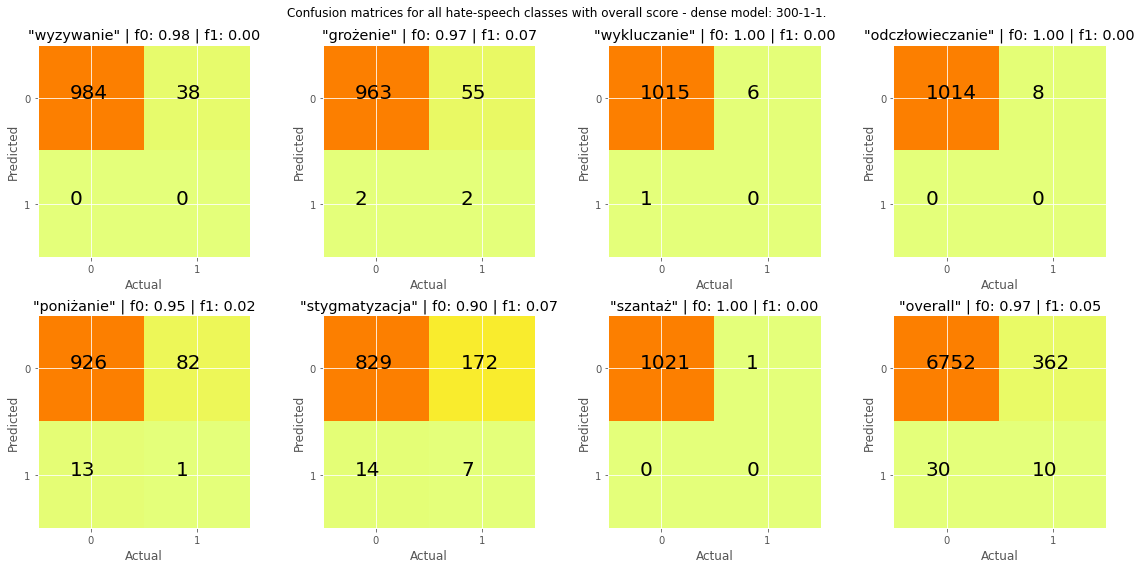

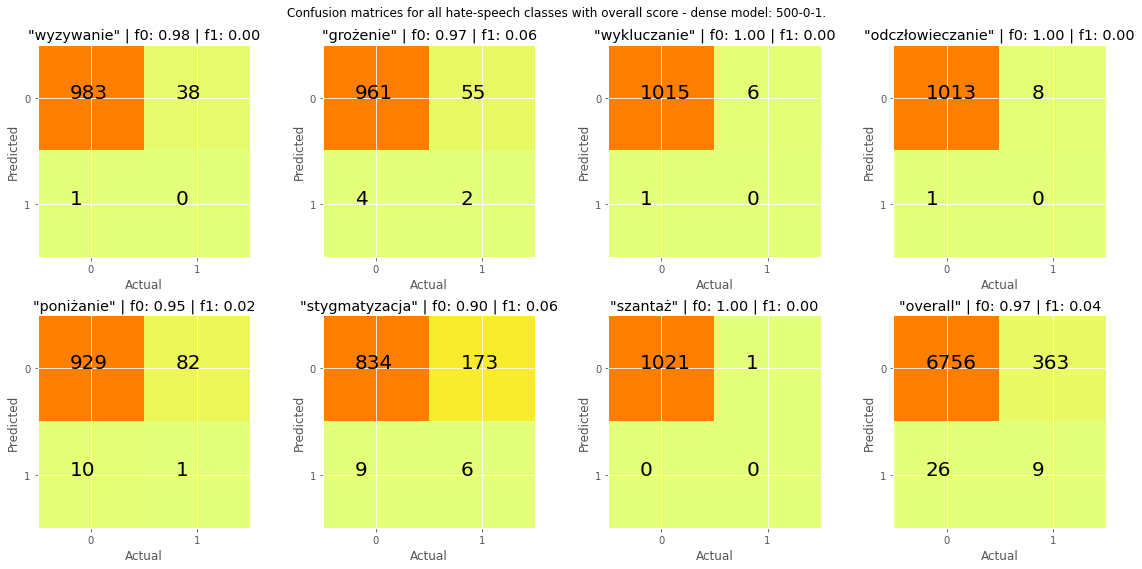

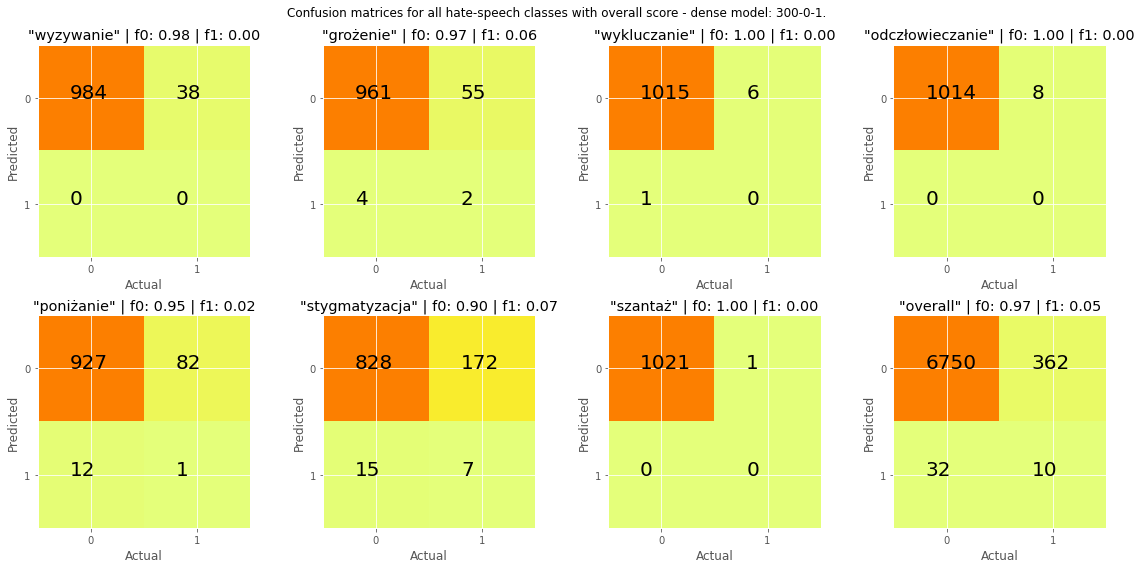

In [14]:
vkwargs = dict({'model_type': 's', 'short_name': 'super'})
for mkwargs, mlabel in tqdm(zip(MODEL_KWARGS, MODEL_LABELS), total=len(MODEL_LABELS), leave=False):
    clf = DLVectorClassifier(short_name=mlabel, k_folds=5, weights=weights,
                             vec_class=TextOwnTrainedFTVectorizer, nn_class=DenseNet, nn_type=f'dense_{wlabel}',
                             vec_params=vkwargs, nn_params=mkwargs)
    
    clf.fit(X_data, y_data)
    # clf.load()
    clf.save()
    
    y_pred = clf.predict(X_test_data)
    confusion_matrices(y_test_data, y_pred,
                       title=f'Confusion matrices for all hate-speech classes with overall score - dense model: {mlabel}.',
                       save_file=DLDC_CHART_DIR.replace('{}', f'{wlabel}_confusion_matrices_{mlabel}'))
    y_preds.append(y_pred)
y_preds = np.array(y_preds)

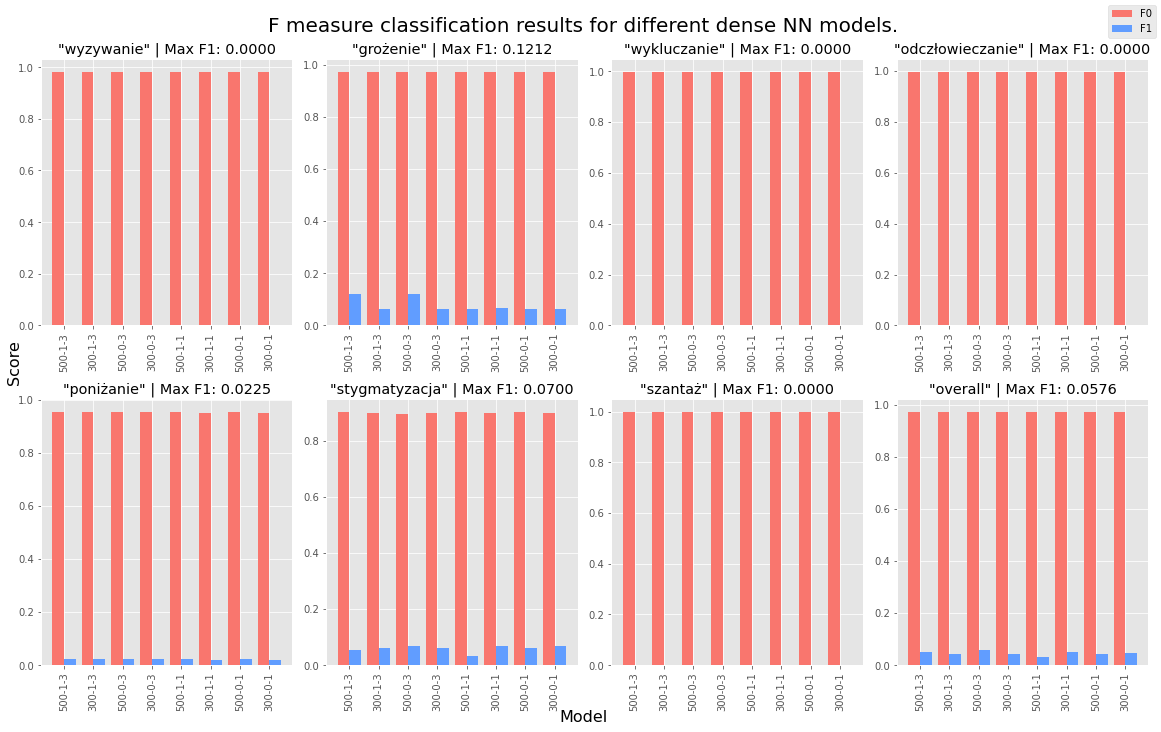

In [15]:
models_quality_plot(y_trues=y_test_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                    title='F measure classification results for different dense NN models.',
                    measure='f', colors=['#f9766e', '#619dff'],
                    save_file=DLDC_CHART_DIR.replace('{}', f'{wlabel}_models_F_bars'))

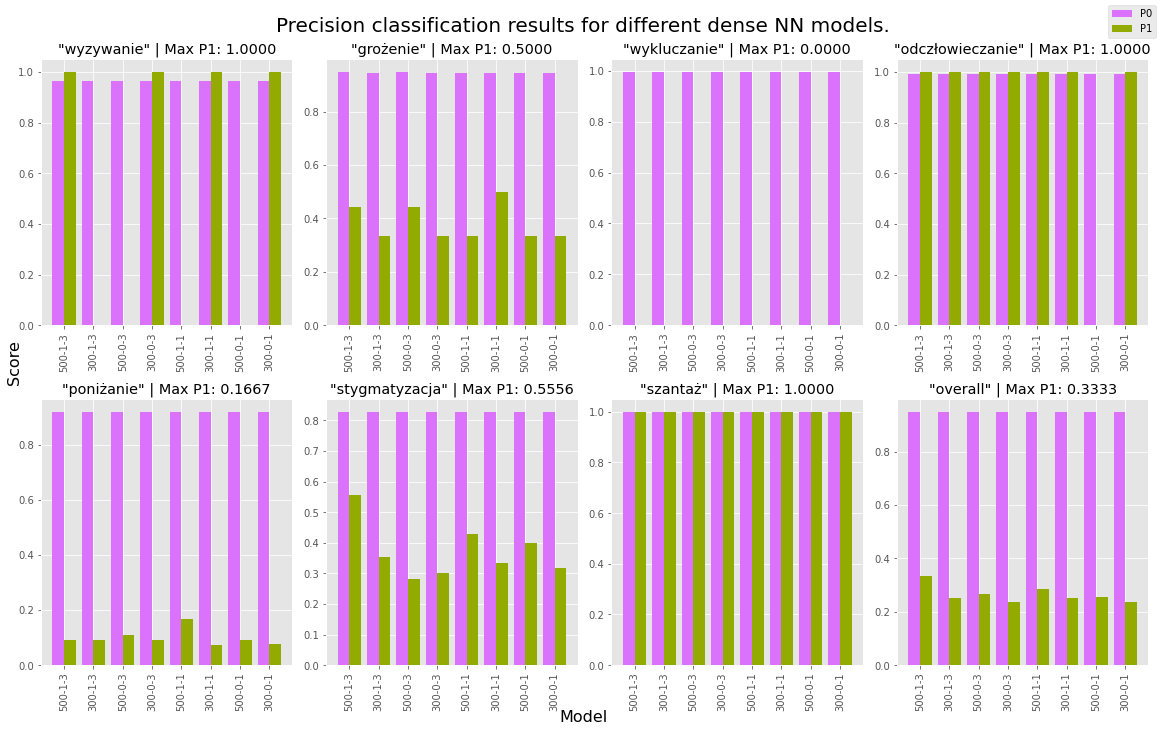

In [16]:
models_quality_plot(y_trues=y_test_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                    title='Precision classification results for different dense NN models.',
                    measure='p', colors=['#da72fb', '#93aa00'],
                    save_file=DLDC_CHART_DIR.replace('{}', f'{wlabel}_models_P_bars'))

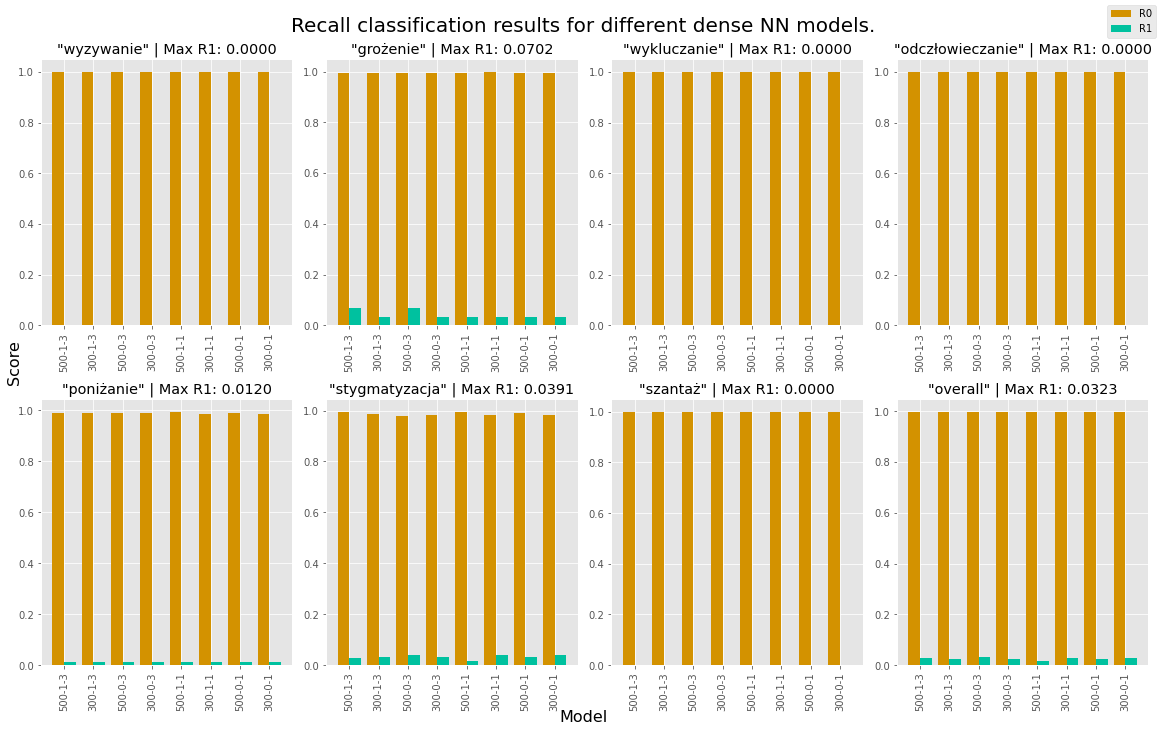

In [17]:
models_quality_plot(y_trues=y_test_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                    title='Recall classification results for different dense NN models.',
                    measure='r', colors=['#d39200', '#00c19f'],
                    save_file=DLDC_CHART_DIR.replace('{}', f'{wlabel}_models_R_bars'))

## Best dense NN model

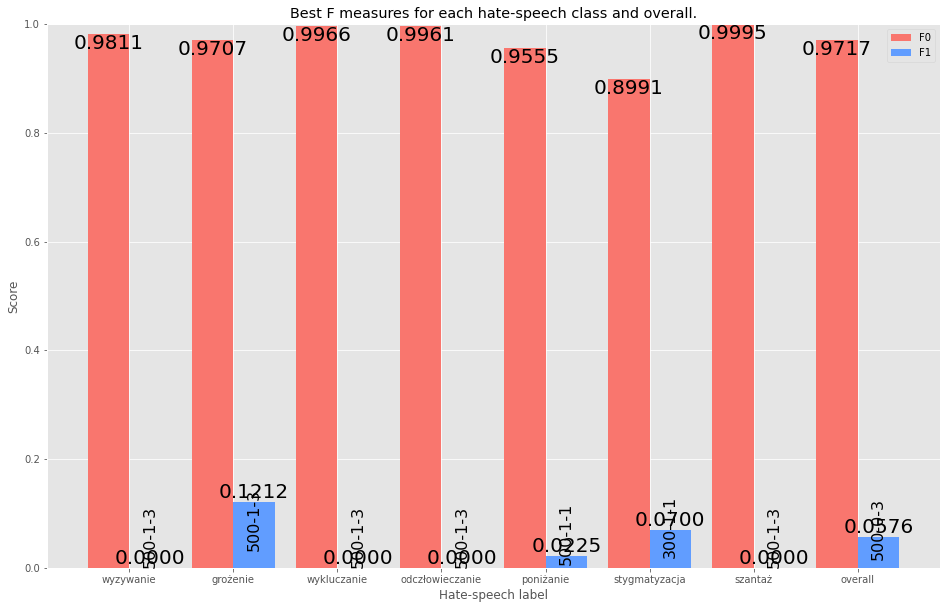

In [18]:
best_model_for_class(y_trues=y_test_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                     title='Best F measures for each hate-speech class and overall.',
                     save_file=DLDC_CHART_DIR.replace('{}', f'{wlabel}_best_F_bars'))

Judging by the above two analyses the best dense NN is that with **300** hidden layer nodes, **dropout** and **1** hidden layer.

In [24]:
vkwargs = dict({'model_type': 's', 'short_name': 'super'})
mkwargs = dict({'hidden_size': 300, 'drop_coeff': 0.1, 'n_linear': 1})
clf = DLVectorClassifier(short_name='300-1-1', k_folds=5,
                         vec_class=TextOwnTrainedFTVectorizer, nn_class=DenseNet, nn_type=f'dense_{wlabel}',
                         vec_params=vkwargs, nn_params=mkwargs)
clf.load()

## Training history

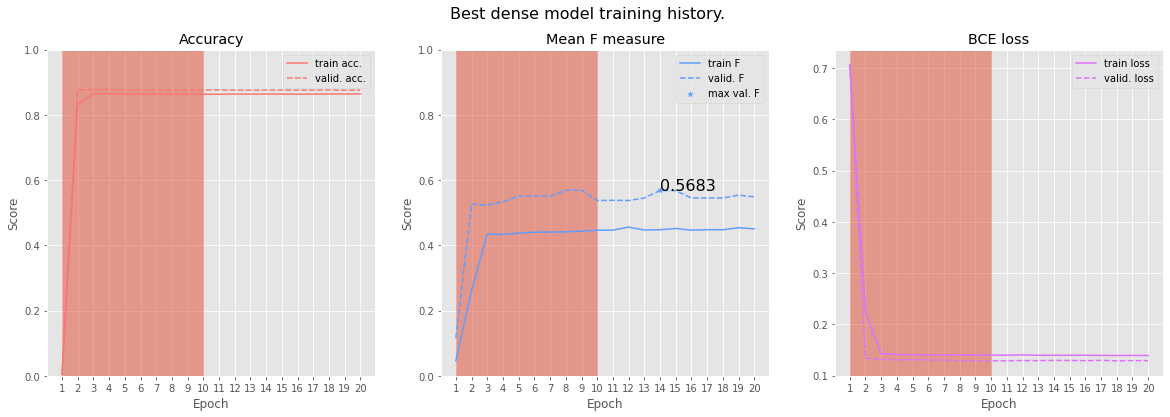

In [25]:
clf.plot_train_history_lines(title='Best dense model training history.',
                             save_file=DLDC_CHART_DIR.replace('{}', f'{wlabel}_best_history_lines'))

## Tests

### Test 1

In [26]:
test_text1 = 'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'
preds1 = clf.test(test_text1)
dict(zip(LABELS, preds1))

{'wyzywanie': 0.0,
 'grożenie': 0.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically should be 'stygmatyzacja' and 'poniżanie' as positive. (**5/7 correct**) but no positives!

### Test 2

In [27]:
test_text2 = 'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'
preds2 = clf.test(test_text2)
dict(zip(LABELS, preds2))

{'wyzywanie': 0.0,
 'grożenie': 0.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically should be 'grożenie', 'wykluczanie', 'poniżanie' and 'stygmatyzacja' as positive. (**3/7 correct**) but no positives!

### Test 3

In [28]:
test_text3 = 'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '
preds3 = clf.test(test_text3)
dict(zip(LABELS, preds3))

{'wyzywanie': 0.0,
 'grożenie': 0.0,
 'wykluczanie': 0.0,
 'odczłowieczanie': 0.0,
 'poniżanie': 0.0,
 'stygmatyzacja': 0.0,
 'szantaż': 0.0}

Empirically should be: 'grożenie' as positive. (**6/7 correct**) but no positives!